# 영화 장르 간 편향성 분석 (WEAT) - 최종본

## STEP 1: 설정 및 전처리 함수 정의

In [1]:
# 1-1. 필요한 라이브러리를 모두 임포트합니다.
import os
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# 1-2. 기본 설정 및 Okt 객체 생성 (성능을 위해 한 번만 생성)
data_dir = "data"
okt = Okt()

# 1-3. 기본 불용어 및 노이즈 키워드 정의
basic_stopwords = {
    "그리고", "하지만", "그러나", "그래서", "때문", "위해", "으로", "에서", "까지", "또한",
    "통해", "대한", "등등", "다시", "하며", "또는", "에게", "보다", "더욱", "같이",
    "작품", "관객", "연출", "출연", "이야기", "장면", "감독", "제작", "주연",
    "촬영", "개봉", "극장", "제작진", "스텝", "스크린", "상영",
    "한다", "되다", "이다", "같다", "하다", "이번", "어떤", "어느", "것", "그", "그것"
}
noise_keywords = ['영화제', 'FESTIVAL', '초청', '부문']

# 1-4. 최종 전처리 함수 정의
def preprocess(file_path, okt_analyzer, current_stopwords):
    """하나의 파일을 읽어 전처리 및 토큰화하는 전체 과정을 수행"""
    tokenized_corpus = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # 1차: 라인 단위 노이즈 제거
            if any(keyword in line for keyword in noise_keywords):
                continue

            # 2차: 괄호 제거
            cleaned = re.sub(r'\[.*?\]|\(.*?\)', '', line)

            # 3차: 문장 단위 노이즈 제거
            sentences = cleaned.split('.')
            kept_sentences = [s for s in sentences if not any(keyword in s for keyword in noise_keywords)]
            cleaned = '. '.join(kept_sentences)

            # 4차: 한글제외, 영어 및 특수문자 등 제거 (영어 문장도 나오는데 보면 한글이 한번 나오고 중복으로 번역한 내용이라 영어도 다 삭제)
            cleaned = re.sub(r'[^가-힣\s]', ' ', cleaned)
            cleaned = re.sub(r'\s+', ' ', cleaned).strip()
            if not cleaned:
                continue

            # 5차: 형태소 분석 및 최종 토큰화
            words = okt_analyzer.pos(cleaned, stem=True, norm=True)
            tokens = [w for w, pos in words if pos in ["Noun"] and w not in current_stopwords and len(w) > 1]
            if tokens:
                tokenized_corpus.append(tokens)
    return tokenized_corpus

## STEP 2: 데이터 기반 불용어 사전 구축 및 Word2Vec 모델 학습

- 전체 시놉시스(`synopsis.txt`)를 정제하여 Word2Vec 모델 학습을 위한 데이터를 준비
- 일반 불용어 외에, 여러 장르에 걸쳐 자주 나오는 용어는 도메인별 불용어로 추가
- **min_df=5** 설정을 통해, 최소 5개 이상의 영화에 등장하는 단어들만 최종 어휘로 사용하여 `핸리`, `모짜르트` 같은 고유명사 노이즈를 제거


In [2]:
# 2-1. 데이터 기반 불용어 사전 구축
print("데이터 기반 불용어 사전을 구축합니다...")
genre_txt_files = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
                   'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 'synopsis_mystery.txt',
                   'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 'synopsis_adult.txt', 'synopsis_thriller.txt',
                   'synopsis_animation.txt', 'synopsis_action.txt', 'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt',
                   'synopsis_fantasy.txt']
genre_names = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄',
               '사극', '서부극(웨스턴)', '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

# 기본 불용어만으로 장르 말뭉치 생성
genre_corpus_for_stopwords = [' '.join([' '.join(doc) for doc in preprocess(os.path.join(data_dir, f), okt, basic_stopwords)]) for f in genre_txt_files]
vectorizer_for_stopwords = TfidfVectorizer()
X_for_stopwords = vectorizer_for_stopwords.fit_transform(genre_corpus_for_stopwords)
features_for_stopwords = vectorizer_for_stopwords.get_feature_names_out()

top_words_per_genre = [[features_for_stopwords[idx] for idx in np.argsort(X_for_stopwords[i].toarray().flatten())[::-1][:20]] for i in range(len(genre_names))]
word_counts = Counter([word for sublist in top_words_per_genre for word in sublist])

# 15개 이상 장르의 상위 20위 안에 드는 단어를 '도메인 불용어'로 추가
domain_stopwords = {word for word, count in word_counts.items() if count >= 15}
final_stopwords = basic_stopwords.union(domain_stopwords)
print("도메인 불용어 예시:", list(domain_stopwords)[:20])
print(f"최종 불용어 수: {len(final_stopwords)}개")

# 2-2. 최종 불용어를 사용하여 전체 시놉시스 다시 전처리
full_corpus_path = os.path.join(data_dir, "synopsis.txt")
print(f"'{full_corpus_path}' 파일 최종 전처리 중...")
tokenized_corpus = preprocess(full_corpus_path, okt, final_stopwords)
print(f"전처리 후 총 문장 수: {len(tokenized_corpus)}")

# 2-3. min_df 기준으로 어휘 사전 구축 및 데이터 필터링
detokenized = [' '.join(doc) for doc in tokenized_corpus if doc]
vectorizer = CountVectorizer(min_df=5)
vectorizer.fit(detokenized)
vocabulary = set(vectorizer.get_feature_names_out())
print(f"필터링 후 최종 어휘 수: {len(vocabulary)}")
filtered_tokenized = [[word for word in doc if word in vocabulary] for doc in tokenized_corpus]

# 2-4. Word2Vec 모델 학습
print("Word2Vec 모델 학습 시작...")
model = Word2Vec(filtered_tokenized, vector_size=100, window=5, min_count=3, sg=1)
print("Word2Vec 모델 학습 완료!")

데이터 기반 불용어 사전을 구축합니다...
도메인 불용어 예시: ['그녀', '시작', '사람', '자신']
최종 불용어 수: 51개
'data/synopsis.txt' 파일 최종 전처리 중...
전처리 후 총 문장 수: 60331
필터링 후 최종 어휘 수: 14574
Word2Vec 모델 학습 시작...
Word2Vec 모델 학습 완료!


## STEP 3: Target 및 Attribute 단어 셋 구축

- **Target (타겟):** '일반/상업 영화' vs '예술 영화'
- **Attribute (속성):** 21개의 각 영화 장르


In [3]:
# --- 설정 ---
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'
n = 15 # 추출할 대표 단어 수

# --- Target 단어셋 구축 ---
art_corpus = ' '.join([' '.join(doc) for doc in preprocess(os.path.join(data_dir, art_txt), okt, final_stopwords)])
gen_corpus = ' '.join([' '.join(doc) for doc in preprocess(os.path.join(data_dir, gen_txt), okt, final_stopwords)])

target_vectorizer = TfidfVectorizer()
target_X = target_vectorizer.fit_transform([art_corpus, gen_corpus])
target_features = target_vectorizer.get_feature_names_out()

diff_scores = (target_X[0] - target_X[1]).toarray().flatten()
sorted_indices = np.argsort(diff_scores)

# TF-IDF 점수 차이를 기준으로, 예술영화에 가까운 단어와 일반영화에 가까운 단어를 각각 15개 씩 추출
# Word2Vec 모델에 없는 단어는 후보에서 제외
target_art_words = [word for word in [target_features[idx] for idx in sorted_indices[::-1]] if word in model.wv][:n]
target_gen_words = [word for word in [target_features[idx] for idx in sorted_indices] if word in model.wv][:n]

print(f"Target Art Words (n={len(target_art_words)}):", target_art_words)
print(f"Target Gen Words (n={len(target_gen_words)}):", target_gen_words)

# --- Attribute 단어셋 구축 ---

genre_corpus_list = [' '.join([' '.join(doc) for doc in preprocess(os.path.join(data_dir, f), okt, final_stopwords)]) for f in genre_txt_files]
attr_vectorizer = TfidfVectorizer()
attr_X = attr_vectorizer.fit_transform(genre_corpus_list)
attr_features = attr_vectorizer.get_feature_names_out()

top_words_per_genre = [[attr_features[idx] for idx in np.argsort(attr_X[i].toarray().flatten())[::-1][:100]] for i in range(len(genre_names))]
word_counts = Counter([word for sublist in top_words_per_genre for word in sublist])

multiplier = 1.5 # 1단계 후보 선정 기준

# 1. 각 장르별로 상대적 중요도가 높은 후보 단어 추출
candidate_words_per_genre = []
for i in range(len(genre_names)):
    scores = attr_X[i].toarray().flatten()
    other_scores_mean = np.mean(np.delete(attr_X.toarray(), i, axis=0), axis=0)

    candidate_indices = np.where(scores > other_scores_mean * multiplier)[0]
    sorted_candidate_indices = sorted(candidate_indices, key=lambda idx: scores[idx], reverse=True)

    candidates = [attr_features[idx] for idx in sorted_candidate_indices if attr_features[idx] in model.wv]
    candidate_words_per_genre.append(candidates)

# 2. 전체 후보 단어 목록에서 각 단어의 빈도수 계산
all_candidate_words = [word for sublist in candidate_words_per_genre for word in sublist]
word_counts = Counter(all_candidate_words)

# 3. 빈도수가 1인 유니크 단어들만 최종 대표 단어로 선정하려고 했으나, 그렇게 하니까 아예 안나오는 장르도 있어서
# 3개로 좀 느슨하게 해줌. 드라마, 멜로로맨스는 단어가 겹치지 않는게 이상하니까 너무 옥죄려고 하다가 성능이 안좋아지는...
attributes = []
for i in range(len(genre_names)):
    unique_words = [word for word in top_words_per_genre[i] if word_counts[word] <= 3 and word in model.wv][:n]
    attributes.append(unique_words)

for i, attr in enumerate(attributes):
    print(f"{genre_names[i]} (n={len(attr)}): {attr}")

for i, attr in enumerate(attributes):
    print(f"{genre_names[i]} (n={len(attr)}): {attr}")

Target Art Words (n=15): ['사랑', '과연', '단편', '세상', '인생', '아빠', '마을', '음악', '파리', '가족', '마음', '프랑스', '지금', '청년', '소녀']
Target Gen Words (n=15): ['남편', '관계', '의도', '생각', '섹스', '남자', '여성', '친구', '영화', '모습', '여자', '인간', '다른', '애니메이션', '주인공']
SF (n=15): ['인류', '우주선', '외계', '시간', '존재', '사실', '한편', '아들', '스타크', '리플리', '수퍼맨', '아버지', '컨트', '모두', '임무']
가족 (n=15): ['아버지', '아들', '낙타', '씨제이', '동구', '미아', '가장', '어머니', '엠마', '케이시', '모두', '크리스마스', '고양이', '스튜어트', '혜지']
공연 (n=15): ['오페라', '토스카', '실황', '올레', '카바', '프레', '공연', '베르디', '오텔로', '리골레토', '백작', '카르피', '콘서트', '백작부인', '반니']
공포(호러) (n=15): ['공포', '악령', '사실', '하나', '저주', '시간', '점점', '이후', '모두', '계속', '아버지', '파티', '다른', '과연', '유령']
기타 (n=15): ['다른', '시간', '이미지', '아버지', '사이', '하나', '아들', '간다', '의도', '남편', '뉴미디어', '페스티벌', '순간', '단편영화', '모두']
다큐멘터리 (n=15): ['다큐멘터리', '한국', '시간', '기록', '가장', '다른', '투쟁', '지역', '과정', '아버지', '하나', '이자', '문화', '이후', '운동']
드라마 (n=15): ['아버지', '아들', '남편', '시간', '다른', '사이', '사실', '어머니', '하나', '간다', '점점', '인생', '순간', '의도', '모두']
멜

## STEP 4. WEAT Score 계산 및 시각화

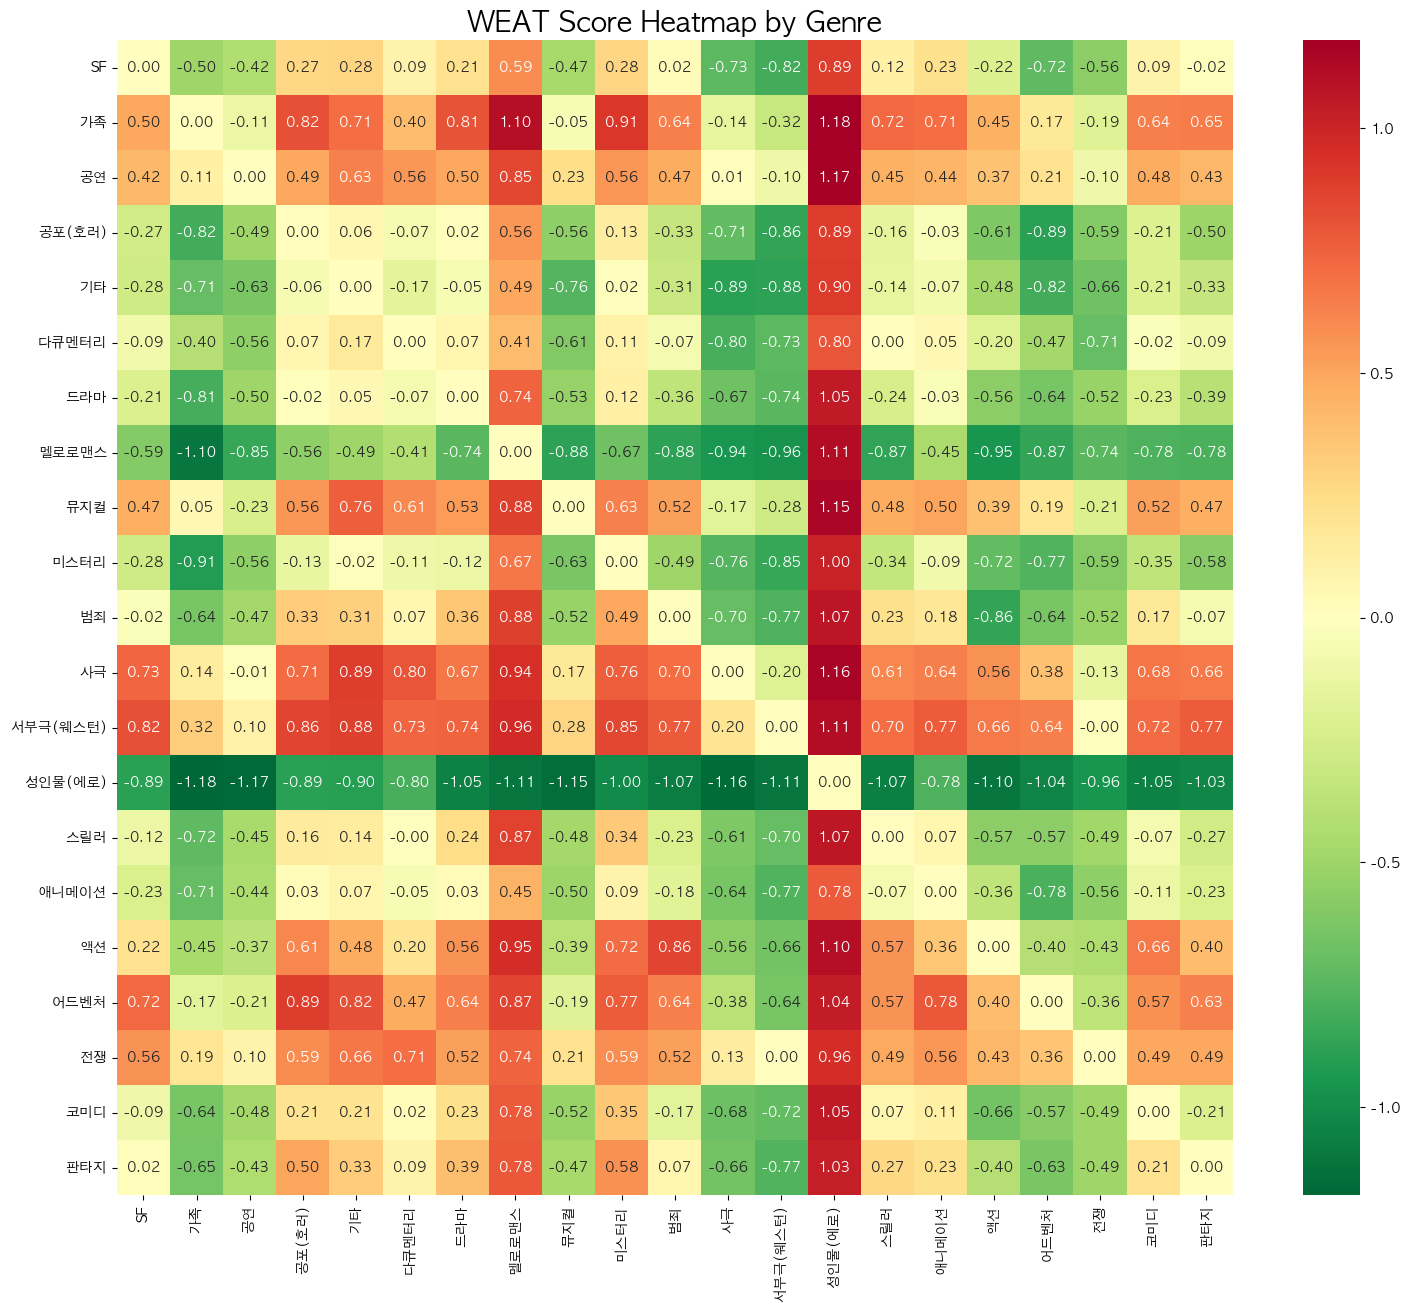

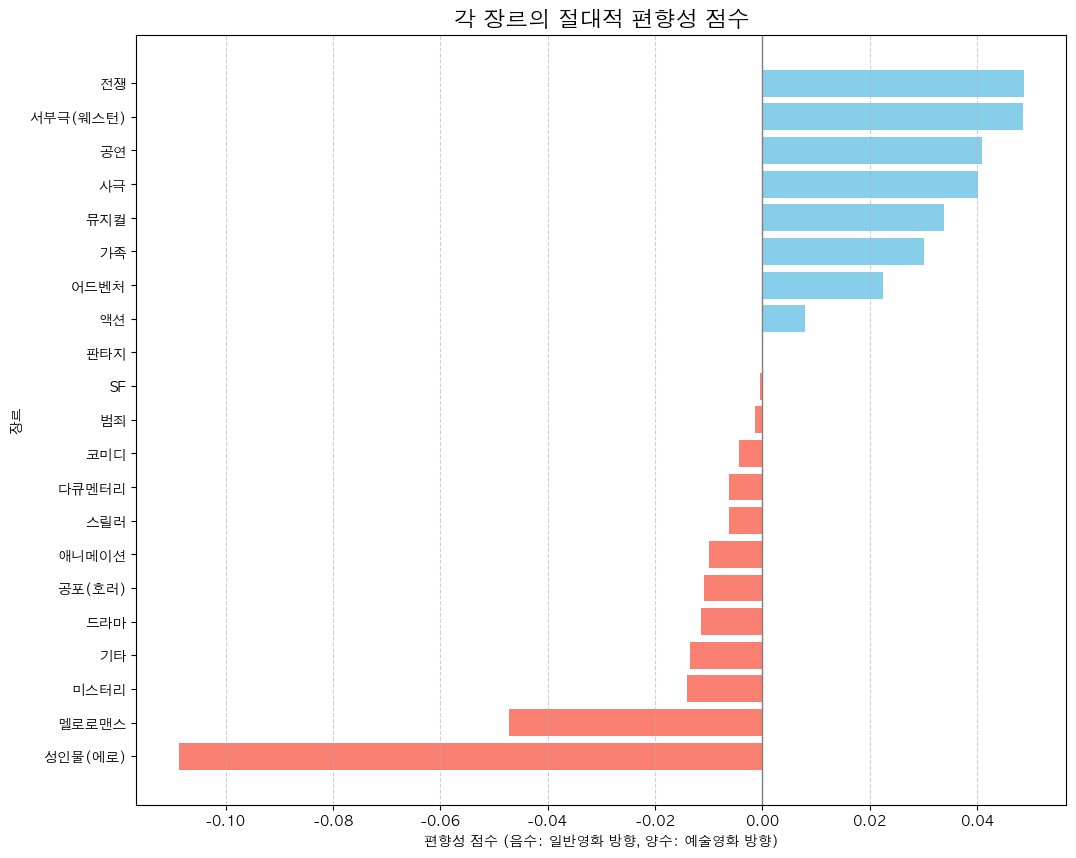

In [5]:
# 4-1. WEAT Score 계산 함수 및 로직
def s(w, A, B):
    mean_A = np.mean([cosine_similarity([w], [a])[0][0] for a in A])
    mean_B = np.mean([cosine_similarity([w], [b])[0][0] for b in B])
    return mean_A - mean_B

def weat_score(X, Y, A, B):
    s_X = np.array([s(w, A, B) for w in X])
    s_Y = np.array([s(w, A, B) for w in Y])
    mean_X, mean_Y = np.mean(s_X), np.mean(s_Y)
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    return (mean_X - mean_Y) / std_dev if std_dev != 0 else 0

X_emb = np.array([model.wv[word] for word in target_art_words])
Y_emb = np.array([model.wv[word] for word in target_gen_words])
matrix = [[0 for _ in range(len(genre_names))] for _ in range(len(genre_names))]

for i in range(len(genre_names)):
    for j in range(i + 1, len(genre_names)):
        A_emb = np.array([model.wv[word] for word in attributes[i] if word in model.wv])
        B_emb = np.array([model.wv[word] for word in attributes[j] if word in model.wv])
        if len(A_emb) == 0 or len(B_emb) == 0: continue
        score = weat_score(X_emb, Y_emb, A_emb, B_emb)
        matrix[i][j] = score
        matrix[j][i] = -score

# 4-2. 시각화 1: 상대적 편향성 (Heatmap)
# 한글 지원 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(matrix, xticklabels=genre_names, yticklabels=genre_names, annot=True, cmap='RdYlGn_r', fmt='.2f', ax=ax)
ax.set_title('WEAT Score Heatmap by Genre', fontsize=20)
plt.show()

# 4-3. 시각화 2: 절대적 편향성 (Bar Chart)
def absolute_weat_score(A, X, Y):
    s_A = np.array([s(a, X, Y) for a in A])
    return np.mean(s_A)

absolute_scores = {
    genre_names[i]: absolute_weat_score(np.array([model.wv[w] for w in attributes[i] if w in model.wv]), X_emb, Y_emb)
    for i in range(len(genre_names)) if attributes[i]
}
sorted_scores = sorted(absolute_scores.items(), key=lambda item: item[1])
genres = [item[0] for item in sorted_scores]
scores = [item[1] for item in sorted_scores]

plt.figure(figsize=(12, 10))
plt.barh(genres, scores, color=['skyblue' if s > 0 else 'salmon' for s in scores])
plt.title('각 장르의 절대적 편향성 점수', fontsize=16)
plt.xlabel('편향성 점수 (음수: 일반영화 방향, 양수: 예술영화 방향)')
plt.ylabel('장르')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.axvline(0, color='grey', linewidth=1)
plt.show()

## 결론 및 회고

본 프로젝트는 주어진 영화 시놉시스 데이터를 바탕으로, WEAT(Word Embedding Association Test)를 이용해 장르 간에 숨겨진 의미적 편향성을
측정하고 분석하는 것을 목표로 진행했습니다.

### 주요 학습 과정 및 문제 해결

1. 초기 접근과 한계 발견
    * LMS에서 제안된 '상위 100개 중 겹치지 않는 단어 추출' 방식보다 발전된 'TF-IDF 점수 차이' 방식을 적용하며 분석을 시작했습니다. 하지만 이
        방식 역시 '마을'처럼 여러 장르에 공통으로 사용되는 단어나, '헨리'와 같이 특정 작품에만 등장하는 고유명사를 완벽히 걸러내지 못하는 한계가
        있었습니다.
    * 반면, '블록버스터', '흥행' 등 수동으로 대표 단어를 지정했을 때 더 직관적인 결과가 나오는 것을 통해, 대표 단어 셋의 품질이 전체 분석
        결과에 결정적인 영향을 미침을 초기에 확인할 수 있었습니다.

2. 전처리 및 단어 추출 방법론의 점진적 발전
    * '주어진 데이터 내에서 최선의 결과'를 얻는 것을 목표로, 발견된 문제들을 해결하기 위해 다음과 같이 방법론을 점진적으로 발전시켰습니다.
        1. 데이터 정제: 영화제 정보 등 내용과 무관한 메타데이터를 제거했습니다.
        2. 고유명사 제거: min_df 옵션을 활용하여 소수의 영화에만 등장하는 고유명사성 단어를 필터링했습니다.
        3. 도메인 불용어 처리: 여러 장르에 공통으로 등장하는 보편적 단어('친구', '가족' 등)를 '도메인 불용어'로 지정하여 제거했습니다.
        4. 유사 장르 클러스터링 허용: 'SF'와 '액션'처럼 유사 장르 간에는 일부 대표 단어를 공유할 수 있도록, Attribute 단어 추출 시 유일성
            조건을 완화했습니다.

3. '과유불급': 전처리 과정에서의 교훈
    * 전처리 과정을 강화하며 '과도한 규제가 오히려 결과를 왜곡시킬 수 있다'는 중요한 사실을 발견했습니다. 예를 들어, 너무 많은 단어를
        '보편적'이라는 이유로 불용어 처리하자, '일반 영화'의 대표 단어가 '성인물' 장르의 단어들로 치우치는 현상이 발생했습니다. 이는 '성인물'
        장르의 어휘가 다른 장르와 겹치지 않아 통계적으로 '독보적인' 특징으로 부각되었기 때문입니다. 이를 통해 적절한 규제 수준을 찾는 '튜닝'의
        중요성을 배울 수 있었습니다.

한계점 및 아쉬운 점

* 데이터셋의 한계: 
    * '공연'과 같은 특정 장르는 데이터의 양이 매우 적어 통계적 대표성을 갖기 어려웠습니다. 또한, '일반(상업)영화'를 대표하는 synopsis_gen.txt 데이터셋이 '블록버스터'보다는 여러 장르가 혼합된, 특징 없는 데이터에 가까워, '흥행', '헐리우드' 같은 명확한 상업적 키워드를 추출하는 데 근본적인 한계가 있었습니다.
    * 판타지 영화 하나 시놉시스에 `알렉스`라는 이름만 27번 나와 그게 판타지 영화를 대표하는 키워드로 뽑힌 것 같은데,, 시놉시스 길이가 천차만별인 것도 전처리에서 우선적으로 truncate를 하든지 했어야 할 것 같습니다.

* 개인적인 아쉬움: '이동진'과 같은 평론가 이름이나 'CG', '슈퍼히어로' 같은 키워드를 더 효과적으로 분석에 포함할 수 있는 방법에 대해 추가적인
    탐구가 필요하다고 느꼈습니다. 이것이 데이터셋의 한계인지, 저의 분석 기술의 한계인지 명확히 구분하기 어려운 점이 아쉬웠습니다.

### 최종 회고

결론적으로, 이번 프로젝트는 단순히 WEAT 점수를 계산하는 것을 넘어, 데이터의 본질적인 특성과 한계를 이해하고, 그 안에서 최선의 결과를 얻기 위해 방법론을 점진적으로 개선해나가는 데이터 분석의 전 과정을 깊이 있게 체험할 수 있었던 과정이었다. 특히, '좋은 대표 단어'를 어떻게 정의하고 추출하는지가 전체 분석의 성패를 좌우한다는 점을 명확히 배울 수 있었습니다.

```
로코왕국의 영웅 ‘드래곤스타’의 펫 ‘아벨’이 위험에 처했다!
 소원을 들어주는 엘프들의 왕 ‘엘프킹’만이 ‘아벨’을 구해줄 수 있다는 이야기를 듣고
 다섯 명의 드래곤 나이트 ‘드래곤스타’, ‘파비아’, ‘타오’, ‘알도’, ‘렐프’는 그들의 펫과 함께 기나긴 여정을 떠나게 된다.
 하지만!
 ‘엘프킹’을 노리는 악의 무리 ‘돌머리 흑사단’은 이들의 여정을 방해하고,
 가장 큰 단서를 가지고 있는 ‘엘프킹’의 아들 ‘레비’까지 납치하는데…
 그들은 과연 ‘엘프킹’의 아들 ‘레비’와 ‘아벨’을 모두 구해낼 수 있을까?
NEW YORK 명품을 휘감고 파티를 즐기던 뉴욕 상위 1%의 ‘재스민’!
 사업가 ‘할’과의 결혼으로 부와 사랑을 모두 가지게 된 ‘재스민’. 뉴욕 햄튼에 위치한 고급 저택에서 파티를 열고, 맨해튼 5번가에서 명품 쇼핑을 즐기던 상위 1% 그녀의 인생이 산산조각 난다. 바로, ‘할’의 외도를 알게 된 것.
 SAN FRANCISCO 모든 것을 잃은 그녀, 화려하지만 우울하다!
 결혼생활을 끝내버리고 하루아침에 땡전 한 푼 없는 빈털터리가 된 ‘재스민’은 여동생 ‘진저’에게 신세를 지기 위해 샌프란시스코행 비행기에 오른다. 명품샵 하나 없는 샌프란시스코 차이나타운에서 정반대의 삶을 살게 된 그녀. 모든 것은 낯설기만 하고, ‘진저’와 루저같아 보이는 그녀의 남자친구 ‘칠리'가 불편하다. 인정할 수 없는 현실에 혼잣말은 늘어만 가고 신경안정제마저 더 이상 듣지 않던 어느 날, 그녀는 근사한 외교관 ‘드와이트’를 만나면서 한줄기 희망을 발견하는데…
 뉴욕을 떠나 샌프란시스코에서 그녀는 과연 새로운 인생을 찾을 수 있을까?
```

이런식으로 영화별로 들여쓰기가 되어있었는데,,
영화별로 시놉시스를 구분짓는 전처리를 제일 먼저!!! 했어야 했는데, 이건 TODO로 남겨야겠다.